# Swaption prediction using a Hybrid Quantum Reservoir Model

In [1]:
!pip install merlinquantum torch scikit-learn pandas numpy seaborn

In [2]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import merlin
from merlin import QuantumLayer

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import perceval as pcvl

# 1) Hyperparameters and Data Loading

In [3]:
# Data Paths & Preprocessing

torch.manual_seed(42)

TRAIN_FILE = "train.xlsx"

INCOMPLETE_PATH = 'price.xlsx'

# Model Hyperparameters
N_MODES =  8               # Number of optical modes (qubits equivalent)
N_PHOTONS = 4              # Number of photons
BATCH_SIZE = 32            # batch sizing data for training
EPOCHS = 100               # Number of Epochs for training loop
LEARNING_RATE = 0.00005    # learning rate for training algorithm

In [4]:
#DATA LOADING and indentification
df_train = pd.read_excel(TRAIN_FILE)
df_train["Date"] = pd.to_datetime(df_train["Date"], format="%d/%m/%Y")

# Identify swaption columns
swaption_cols = [c for c in df_train.columns if c.startswith("Tenor")]

print("Training dataset loaded.")
print("Columns:", len(swaption_cols), "swaptions found.")

# Data Sampling
df_sample = pd.read_excel(INCOMPLETE_PATH)
df_sample["Date"] = pd.to_datetime(df_sample["Date"], format="%d/%m/%Y")

def parse_tenor_maturity(col):
    m = re.search(r"Tenor\s*:\s*([0-9.]+);\s*Maturity\s*:\s*([0-9.]+)", col)
    return float(m.group(1)), float(m.group(2))

Training dataset loaded.
Columns: 224 swaptions found.


# 2) Data Preprocessing

In [ ]:
#Data preparation
TRAIN_FILE = "train.xlsx"
SAMPLE_FILE = "test_template.xlsx"

# SWAPTION DATASET
class SwaptionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def load_and_process_data(filepath):
    print(f"Loading data from {filepath}...")
    df = pd.read_excel(filepath)

    # Parse dates
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df = df.sort_values('Date').reset_index(drop=True)

    # Extract features (all columns except Date)
    feature_cols = [c for c in df.columns if c != 'Date']
    data_values = df[feature_cols].values

    print(f"Data shape: {data_values.shape} (Days, Surface Points)")

    # Create Input (X) and Target (y)
    X = data_values[:-1]
    y = data_values[1:]

    # Normalisation of the data
    scaler = MinMaxScaler(feature_range=(0,1))
    X_scaled = scaler.fit_transform(X)
    y_scaled = scaler.transform(y)

    return X_scaled, y_scaled, scaler, len(feature_cols)

# Load training data
if not os.path.exists(TRAIN_FILE):
    raise FileNotFoundError(f"Could not find {TRAIN_FILE}. Please ensure it is in the folder.")

X_all, y_all, scaler, INPUT_DIM = load_and_process_data(TRAIN_FILE)

# Split into Train and Test (20% test size)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)

# Create DataLoaders
train_loader = DataLoader(SwaptionDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(SwaptionDataset(X_test, y_test), batch_size=BATCH_SIZE)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Loading data from train.xlsx...
Data shape: (494, 224) (Days, Surface Points)
Training samples: 394
Testing samples: 99


# 3) Model Generation (Linear, PCA, Hybrid-Quantum)

In [6]:
# Baseline Linear Model (not used here)
class LinearModelBaseline(nn.Module):
    def __init__(self, image_size, num_classes=10):
        super(LinearModelBaseline, self).__init__()
        self.image_size = image_size
        self.classifier = nn.Linear(image_size, num_classes)

    def forward(self, x):
        # Data is already flattened
        output = self.classifier(x)
        return output

In [7]:
# LinearModel with PCA
class LinearModelPCA(nn.Module):
    def __init__(self, n_swaps, pca_components):
        super(LinearModelPCA, self).__init__()
        self.n_swaps = n_swaps
        self.pca_components = pca_components

        # Classical part
        self.classifier = nn.Linear(
            n_swaps+pca_components, n_swaps
        )
    def forward(self, x, x_pca):
        # Data is already flattened, just concatenate
        combined_features = torch.cat((x, x_pca), dim=1)
        output = self.classifier(combined_features)
        return output

In [8]:
# QuantumReservoir class - quantum layer applying on pca
class QuantumReservoir(nn.Module):
    def __init__(self, n_swaps, pca_components, n_modes, n_photons):
        super(QuantumReservoir, self).__init__()
        self.n_swaps = n_swaps
        self.pca_components = pca_components
        self.n_modes = n_modes
        self.n_photons = n_photons

        # Quantum part (non-trainable reservoir)
        self.quantum_layer = self._create_quantum_reservoir(
            pca_components, n_modes, n_photons
        )

        q_dim = self.quantum_layer.output_size

        # Classical part
        self.classifier = nn.Linear(
            n_swaps+q_dim, n_swaps
        )

        print(f"\nQuantum Reservoir Created:")
        print(f"  Input size (PCA components): {pca_components}")
        print(f"  Quantum output size: {self.quantum_layer.output_size}")
        print(f"  Total features to classifier: {n_swaps + self.quantum_layer.output_size}")

    def _create_quantum_reservoir(self, input_size, n_modes, n_photons):
        """Create quantum layer with Series circuit in reservoir mode."""

        builder = merlin.CircuitBuilder(n_modes=n_modes)
        builder.add_angle_encoding()
        builder.add_angle_encoding()
        builder.add_superpositions(depth=1)
        builder.add_entangling_layer(trainable=False)
        builder.add_superpositions(depth=1)
        builder.add_angle_encoding()
        builder.add_angle_encoding()
        circuit = builder.circuit


        # Create quantum layer
        quantum_layer = QuantumLayer(
            input_size=input_size,
            builder=builder,
            n_photons=n_photons,
            no_bunching=False,
            measurement_strategy=merlin.MeasurementStrategy.PROBABILITIES,
            )

        return quantum_layer

    def forward(self, x, x_pca):
        # Process the PCA-reduced input through quantum layer
        quantum_output = self.quantum_layer(x_pca)

        # Concatenate original features with quantum output
        combined_features = torch.cat((x, quantum_output), dim=1)

        # Final classification
        output = self.classifier(combined_features)
        return output


In [9]:
n_components=N_MODES*4

# train PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=n_components)

# Note: Data is already flattened
X_train_flat = X_train
X_test_flat = X_test

pca.fit(X_train_flat)
X_train_pca = torch.FloatTensor(pca.transform(X_train_flat))
X_test_pca = torch.FloatTensor(pca.transform(X_test_flat))
print(X_train_pca)

X_train_tensor = torch.FloatTensor(X_train_flat)
X_test_tensor = torch.FloatTensor(X_test_flat)
y_test_tensor = torch.FloatTensor(y_test)

tensor([[-4.7495e+00,  4.5251e-01,  1.0974e-01,  ...,  4.8383e-05,
         -6.2104e-06,  3.2952e-05],
        [-4.2649e+00,  4.8458e-01,  1.5561e-01,  ...,  3.4553e-05,
         -7.5313e-06,  1.7492e-05],
        [-4.4656e+00,  4.4418e-01,  1.0201e-01,  ...,  3.5434e-05,
         -1.1094e-05,  1.8261e-05],
        ...,
        [-2.4229e+00, -7.8226e-01, -6.0902e-01,  ...,  2.9609e-05,
         -1.2371e-05, -1.4038e-05],
        [-2.1843e+00, -5.8874e-01, -6.3556e-01,  ...,  2.9316e-05,
         -3.4132e-06, -1.8664e-05],
        [-2.7844e+00, -4.9423e-01, -7.1268e-01,  ...,  6.2861e-05,
         -9.6663e-06, -2.1981e-05]])



Quantum Reservoir Created:
  Input size (PCA components): 32
  Quantum output size: 330
  Total features to classifier: 554


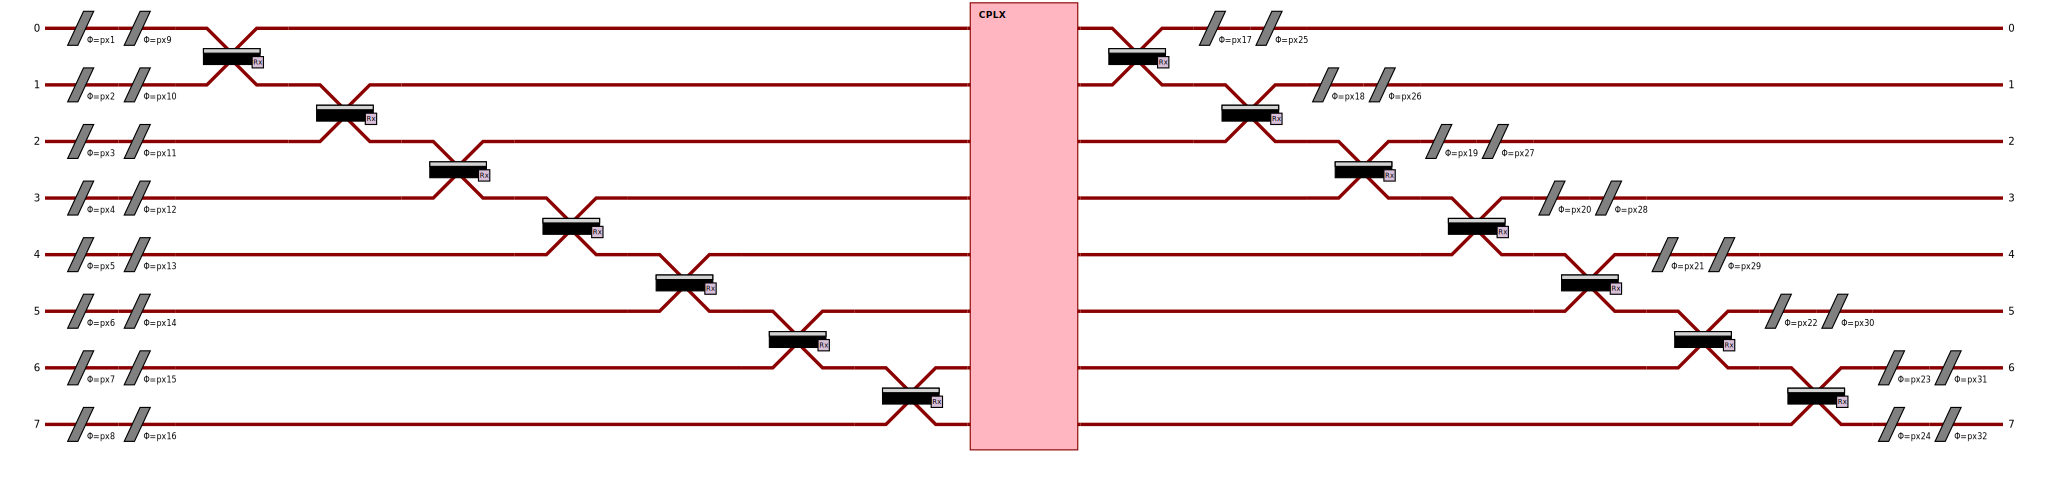

In [10]:
output_dim = X_train_flat.shape[1]

# define corresponding linear model for comparison (not used here)
# linear_model = LinearModelBaseline(X_train_flat.shape[1])

# define model using pca features (not used here)
# pca_model = LinearModelPCA(X_train_flat.shape[1], n_components)

# define hybrid model
hybrid_model = QuantumReservoir(X_train_flat.shape[1], n_components, n_modes=N_MODES, n_photons=N_PHOTONS)
pcvl.pdisplay(hybrid_model.quantum_layer.circuit)

# 4) Testing and Training the Hybrid Model

In [11]:
# Loss function and optimizer
criterion = nn.MSELoss()

optimizer_hybrid = torch.optim.Adam(hybrid_model.parameters(), lr=LEARNING_RATE)

# alternative optimizers (not used further):
# optimizer_linear = torch.optim.Adam(linear_model.parameters(), lr=0.001)
# optimizer_pca = torch.optim.Adam(pca_model.parameters(), lr=0.001)

# Create DataLoader for batching
batch_size = BATCH_SIZE
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, X_train_pca, torch.Tensor(y_train))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Dictionary for quality analysis
history = {
      'hybrid': {'loss': [], 'accuracy': []},
      'pca': {'loss': [], 'accuracy': []},
      'linear': {'loss': [], 'accuracy': []},
      'epochs': []
}

# Main training loop
num_epochs = EPOCHS

for epoch in range(num_epochs):
    running_loss_hybrid = 0.0
    running_loss_linear = 0.0
    running_loss_pca = 0.0

    hybrid_model.train()
    # alternative models:
    # linear_model.train()
    # pca_model.train()

    for i, (n_swaps, pca_features, labels) in enumerate(train_loader):
        # Hybrid model - Forward and Backward pass
        outputs = hybrid_model(n_swaps, pca_features)
        loss = criterion(outputs, labels)
        optimizer_hybrid.zero_grad()
        loss.backward()
        optimizer_hybrid.step()
        running_loss_hybrid += loss.item()

        # # Comparative linear model - Forward and Backward pass
        # outputs = linear_model(images)
        # loss = criterion(outputs, labels)
        # optimizer_linear.zero_grad()
        # loss.backward()
        # optimizer_linear.step()
        # running_loss_linear += loss.item()

        # # Comparative pca model - Forward and Backward pass
        # outputs = pca_model(images, pca_features)
        # loss = criterion(outputs, labels)
        # optimizer_pca.zero_grad()
        # loss.backward()
        # optimizer_pca.step()
        # running_loss_pca += loss.item()

    avg_loss_hybrid = running_loss_hybrid/len(train_loader)
    # avg_loss_linear = running_loss_linear/len(train_loader)
    # avg_loss_pca = running_loss_pca/len(train_loader)

    history['hybrid']['loss'].append(avg_loss_hybrid)
    # history['linear']['loss'].append(avg_loss_linear)
    # history['pca']['loss'].append(avg_loss_pca)

    history['epochs'].append(epoch + 1)

    hybrid_model.eval()
    # alternative models:
    # linear_model.eval()
    # pca_model.eval()

    # Cast X_test to tensor if it isn't already
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)

    # Model Testing
    with torch.no_grad():
        # Hybrid
        outputs = hybrid_model(X_test_tensor, X_test_pca)
        hybrid_test_loss = criterion(outputs, y_test_tensor).item()

        # # Linear
        # outputs = linear_model(X_test_tensor)
        # linear_test_loss = criterion(outputs, y_test_tensor).item()

        # # PCA
        # outputs = pca_model(X_test_tensor, X_test_pca)
        # pca_test_loss = criterion(outputs, y_test_tensor).item()

    # Append losses
    history['hybrid']['accuracy'].append(hybrid_test_loss)
    
    # history['linear']['accuracy'].append(linear_test_loss)
    # history['pca']['accuracy'].append(pca_test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'TRAIN LOSS -- Hybrid: {avg_loss_hybrid:.4f} \n'
          f'TEST LOSS -- Hybrid: {hybrid_test_loss:.4f}')

Epoch [1/100], TRAIN LOSS -- Hybrid: 0.2190 
TEST LOSS -- Hybrid: 0.0759
Epoch [2/100], TRAIN LOSS -- Hybrid: 0.1675 
TEST LOSS -- Hybrid: 0.0580
Epoch [3/100], TRAIN LOSS -- Hybrid: 0.1289 
TEST LOSS -- Hybrid: 0.0441
Epoch [4/100], TRAIN LOSS -- Hybrid: 0.0964 
TEST LOSS -- Hybrid: 0.0337
Epoch [5/100], TRAIN LOSS -- Hybrid: 0.0741 
TEST LOSS -- Hybrid: 0.0259
Epoch [6/100], TRAIN LOSS -- Hybrid: 0.0564 
TEST LOSS -- Hybrid: 0.0201
Epoch [7/100], TRAIN LOSS -- Hybrid: 0.0433 
TEST LOSS -- Hybrid: 0.0161
Epoch [8/100], TRAIN LOSS -- Hybrid: 0.0348 
TEST LOSS -- Hybrid: 0.0131
Epoch [9/100], TRAIN LOSS -- Hybrid: 0.0280 
TEST LOSS -- Hybrid: 0.0109
Epoch [10/100], TRAIN LOSS -- Hybrid: 0.0237 
TEST LOSS -- Hybrid: 0.0094
Epoch [11/100], TRAIN LOSS -- Hybrid: 0.0201 
TEST LOSS -- Hybrid: 0.0083
Epoch [12/100], TRAIN LOSS -- Hybrid: 0.0178 
TEST LOSS -- Hybrid: 0.0075
Epoch [13/100], TRAIN LOSS -- Hybrid: 0.0158 
TEST LOSS -- Hybrid: 0.0069
Epoch [14/100], TRAIN LOSS -- Hybrid: 0.0142 
T

# 5) Model Performance Parameters

In [12]:
# Calculate statistical model quality parameters
mse = mean_squared_error(y_test_tensor, outputs)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_tensor, outputs)

print("\n===== HYBRID MODEL PERFORMANCE =====")
print(f"MSE  : {mse:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"R²   : {r2:.6f}")



===== HYBRID MODEL PERFORMANCE =====
MSE  : 0.001975
RMSE : 0.044443
R²   : 0.826740


# 6) Data Prediction and Completion using the trained hybrid model

In [ ]:

PREDICT_FILE = "test_template.xlsx.xlsx"             # file with missing prediction values
OUTPUT_FILE = "filled_predictions.csv"  # output PATH

print(f"Loading template from {PREDICT_FILE}...")

# CSV parsing, or fallback to Excel 
try:
    df_pred = pd.read_csv(PREDICT_FILE)
except:
    df_pred = pd.read_excel(PREDICT_FILE.replace(".csv", ""))

# Identification of feature columns to be predicted (excluding metadata columns)
metadata_cols = ['Date', 'Type', 'Unnamed: 0']
feature_cols = [c for c in df_pred.columns if c not in metadata_cols]

print(f"Found {len(feature_cols)} feature columns to predict.")

# Starting State preparation (last state from the training data to be used for first future step prediction)
last_state_scaled = y_all[-1]

# Recursive Prediction Loop
print(f"Generating predictions for {len(df_pred)} steps...")
predictions_scaled = []
current_input = last_state_scaled.reshape(1, -1) # Shape (1, n_features)

hybrid_model.eval() # Set model to evaluation mode

with torch.no_grad():
    for i in range(len(df_pred)):
        # Raw scaled features
        X_tensor = torch.FloatTensor(current_input)

        # Scaled PCA features
        X_pca_tensor = torch.FloatTensor(pca.transform(current_input))

        # Predict next state (scaled)
        y_next_scaled = hybrid_model(X_tensor, X_pca_tensor)

        # Convert to numpy
        y_next_np = y_next_scaled.numpy()

        # Store prediction
        predictions_scaled.append(y_next_np.flatten())

        # Update current_input for the next step (feeding prediction back as input)
        current_input = y_next_np

predictions_scaled = np.array(predictions_scaled)

# Inverse scale to get actual prices/values
predictions_original = scaler.inverse_transform(predictions_scaled)
df_pred.loc[:, feature_cols] = predictions_original

# Save to output file
df_pred.to_csv(OUTPUT_FILE, index=False)
print(f"Predictions completed and saved to {OUTPUT_FILE}")

# Display first few rows
df_pred.head()

Loading template from price.xlsx...
Found 224 feature columns to predict.
Generating predictions for 8 steps...
Predictions completed and saved to filled_predictions.csv


,Type,Tenor : 1; Maturity : 0.0833333333333333,Tenor : 2; Maturity : 0.0833333333333333,Tenor : 3; Maturity : 0.0833333333333333,Tenor : 4; Maturity : 0.0833333333333333,Tenor : 5; Maturity : 0.0833333333333333,Tenor : 6; Maturity : 0.0833333333333333,Tenor : 7; Maturity : 0.0833333333333333,Tenor : 8; Maturity : 0.0833333333333333,Tenor : 9; Maturity : 0.0833333333333333,...,Tenor : 6; Maturity : 30,Tenor : 7; Maturity : 30,Tenor : 8; Maturity : 30,Tenor : 9; Maturity : 30,Tenor : 10; Maturity : 30,Tenor : 15; Maturity : 30,Tenor : 20; Maturity : 30,Tenor : 25; Maturity : 30,Tenor : 30; Maturity : 30,Date
0,Future prediction,0.026504,0.034805,0.035573,0.037412,0.036505,0.036700,0.035294,0.035185,0.036594,...,0.325256,0.341107,0.334355,0.337350,0.330498,0.352365,0.364548,0.345545,0.336574,2051-12-24
1,Future prediction,0.027271,0.034894,0.035819,0.037822,0.036703,0.036445,0.035937,0.035226,0.036692,...,0.328082,0.341116,0.334023,0.336082,0.332215,0.353194,0.365218,0.346290,0.334920,2051-12-26
2,Future prediction,0.027319,0.035170,0.036249,0.037991,0.036808,0.036625,0.036187,0.035774,0.036890,...,0.328212,0.340768,0.333668,0.335928,0.332033,0.352763,0.364454,0.345547,0.334448,2051-12-27
3,Future prediction,0.027398,0.035305,0.036442,0.038166,0.036954,0.036960,0.036442,0.036058,0.037071,...,0.328272,0.340561,0.333473,0.335442,0.331632,0.352776,0.364207,0.345160,0.334157,2051-12-29
4,Future prediction,0.027403,0.035393,0.036611,0.038352,0.037111,0.037173,0.036642,0.036321,0.037241,...,0.328487,0.340268,0.333107,0.335282,0.331617,0.352536,0.363952,0.344893,0.333942,2051-12-30


# 7) Train and Test convergence results


Training curve saved as 'training_curve.png'


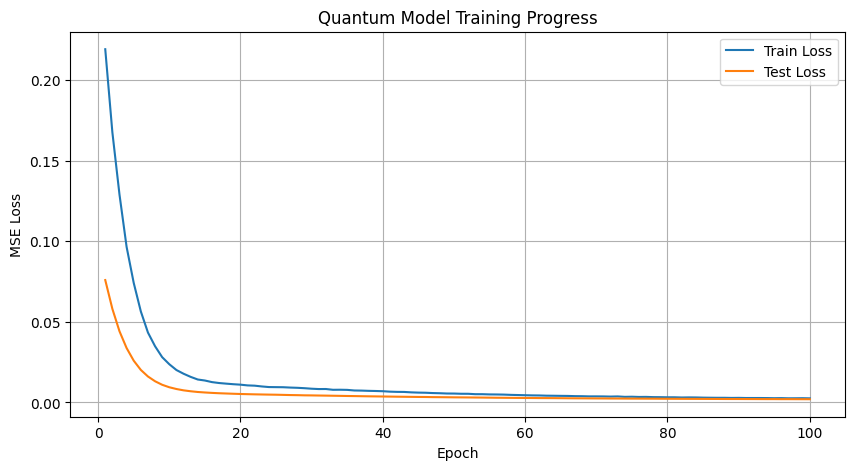

In [14]:
# Plot of the train and test losses for convergence check
plt.figure(figsize=(10, 5))
plt.plot(history['epochs'], history['hybrid']['loss'], label='Train Loss')
plt.plot(history['epochs'], history['hybrid']['accuracy'], label='Test Loss')
plt.title("Quantum Model Training Progress")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.savefig("training_curve.png")
print("\nTraining curve saved as 'training_curve.png'")